<a href="https://colab.research.google.com/github/gal-dmitry/HSE_RecSys/blob/master/HW_02/HW_02_PIPELINE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost==1.0.3
!pip install gensim==4.1.0
!pip install --upgrade numpy

In [2]:
!pip install shap

In [3]:
!wget https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
!tar -xf /content/wsdm_data.tar.gz

--2021-12-15 12:13:55--  https://voudy-data.s3.eu-north-1.amazonaws.com/wsdm_data.tar.gz
Resolving voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)... 52.95.170.32
Connecting to voudy-data.s3.eu-north-1.amazonaws.com (voudy-data.s3.eu-north-1.amazonaws.com)|52.95.170.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613394184 (585M) [application/x-gzip]
Saving to: ‘wsdm_data.tar.gz.1’

wsdm_data.tar.gz.1  100%[===================>] 584.98M  11.1MB/s    in 67s     

2021-12-15 12:15:03 (8.75 MB/s) - ‘wsdm_data.tar.gz.1’ saved [613394184/613394184]



In [4]:
from google.colab import files
files.upload()
files.upload()

Saving data_processing.py to data_processing (1).py
Saving train_utils.py to train_utils (1).py


Saving wikipedia-iso-country-codes.csv to wikipedia-iso-country-codes (1).csv


{'wikipedia-iso-country-codes.csv': b'English short name lower case,Alpha-2 code,Alpha-3 code,Numeric code,ISO 3166-2\nAfghanistan,AF,AFG,004,ISO 3166-2:AF\n\xc3\x85land Islands,AX,ALA,248,ISO 3166-2:AX\nAlbania,AL,ALB,008,ISO 3166-2:AL\nAlgeria,DZ,DZA,012,ISO 3166-2:DZ\nAmerican Samoa,AS,ASM,016,ISO 3166-2:AS\nAndorra,AD,AND,020,ISO 3166-2:AD\nAngola,AO,AGO,024,ISO 3166-2:AO\nAnguilla,AI,AIA,660,ISO 3166-2:AI\nAntarctica,AQ,ATA,010,ISO 3166-2:AQ\nAntigua and Barbuda,AG,ATG,028,ISO 3166-2:AG\nArgentina,AR,ARG,032,ISO 3166-2:AR\nArmenia,AM,ARM,051,ISO 3166-2:AM\nAruba,AW,ABW,533,ISO 3166-2:AW\nAustralia,AU,AUS,036,ISO 3166-2:AU\nAustria,AT,AUT,040,ISO 3166-2:AT\nAzerbaijan,AZ,AZE,031,ISO 3166-2:AZ\nBahamas,BS,BHS,044,ISO 3166-2:BS\nBahrain,BH,BHR,048,ISO 3166-2:BH\nBangladesh,BD,BGD,050,ISO 3166-2:BD\nBarbados,BB,BRB,052,ISO 3166-2:BB\nBelarus,BY,BLR,112,ISO 3166-2:BY\nBelgium,BE,BEL,056,ISO 3166-2:BE\nBelize,BZ,BLZ,084,ISO 3166-2:BZ\nBenin,BJ,BEN,204,ISO 3166-2:BJ\nBermuda,BM,BMU,060,I

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import numpy as np

SEED = 42

In [7]:
from train_utils import *
from data_processing import get_preprocessed_dataset

#### Dataset

Подготовка датасета. Детальное описание: [`HW_02_DATA_PREPROCESSING.ipynb`](https://github.com/gal-dmitry/HSE_RecSys/blob/master/HW_02/HW_02_DATA_PREPROCESSING.ipynb)

In [8]:
%%time
dataset = get_preprocessed_dataset(csv_folder_path=".")

process members...
process songs...
process songs extra info...
merge songs...
process train...


100%|██████████| 3/3 [00:00<00:00, 64.89it/s]


merge train...
get final dataset...
CPU times: user 1min 33s, sys: 3.13 s, total: 1min 36s
Wall time: 1min 36s


In [ ]:
### check reproducibility

# restored = pd.read_pickle("full_extended_train_df.pkl")
# assert restored.equals(dataset)
# del restored

In [9]:
TRAIN_DATASET = TrainDataset(dataset).reduce_by_members(size=1023)

TRAIN_DATASET._df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,gender,registered_via,age_group,registration_init_year,expiration_date_year,song_length,genre_ids,artist_name,composer,lyricist,language,genre_ids_count,artist_name_count,composer_count,lyricist_count,isrc_country,isrc_year
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,DZanD98cLDbuPBiXONSwLFSw8BfI69ErQS23vYJ9UU4=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,224235,465,南拳媽媽,周杰倫,宋健彰,3.0,1,1,1,1,"Taiwan, Province of China",2008
1,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,E6Fm873UEDPv0LATidt2gKwBZZHww2Q04nxTg15N9iE=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,193410,465,張靚穎 (Jane Zhang),張靚穎,沈松,3.0,1,1,1,1,-1,-1
2,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,0TZ4BKn9YES2upK9ZgKgsAUtUClVKHnct79pnA/iPiQ=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,187199,2022,Linkin Park,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2003
3,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,m2YSjnhR3nzx/2WccNYpGWywohyd8fT0xR+skQC9/JQ=,my library,Local playlist more,local-library,1,13,male,9,normal,2006,2017,205635,359,Linkin Park,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2007
4,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,cXpk2ZXiSgkwGo8iGbswBc0lzucL9AH+j/2khmnmOLI=,my library,Local playlist more,local-playlist,0,13,male,9,normal,2006,2017,262687,2022,Starset,FILL_NAN,FILL_NAN,52.0,1,1,0,0,United States,2014


#### CatBoost

In [10]:
%%time
catboost_model = CatBoostModel(loss_function="YetiRank", 
                                 iterations=150, 
                                #  task_type="CPU",
                                 task_type="GPU",
                                 random_state=SEED)

catboost_auc_per_query = get_metric(catboost_model, TRAIN_DATASET, n_splits=5)

--- Split: 1/5 ---
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.38s	remaining: 3m 26s
1:	total: 2.6s	remaining: 3m 12s
2:	total: 3.81s	remaining: 3m 6s
3:	total: 5.02s	remaining: 3m 3s
4:	total: 6.23s	remaining: 3m
5:	total: 7.45s	remaining: 2m 58s
6:	total: 8.67s	remaining: 2m 57s
7:	total: 9.88s	remaining: 2m 55s
8:	total: 11.1s	remaining: 2m 53s
9:	total: 12.3s	remaining: 2m 52s
10:	total: 13.5s	remaining: 2m 50s
11:	total: 14.8s	remaining: 2m 49s
12:	total: 16s	remaining: 2m 48s
13:	total: 17.2s	remaining: 2m 46s
14:	total: 18.4s	remaining: 2m 45s
15:	total: 19.6s	remaining: 2m 44s
16:	total: 20.8s	remaining: 2m 42s
17:	total: 22s	remaining: 2m 41s
18:	total: 23.3s	remaining: 2m 40s
19:	total: 24.5s	remaining: 2m 39s
20:	total: 25.7s	remaining: 2m 37s
21:	total: 26.9s	remaining: 2m 36s
22:	total: 28.2s	remaining: 2m 35s
23:	total: 29.4s	remaining: 2m 34s
24:	total: 30.6s	remaining: 2m 32s
25:	total: 31.8s	remaining: 2m 31s
26:	total: 33s	remaining: 2m 30s
27:	total: 34.2s	remaining: 2m 29s
28:	total: 35.4s	remaining: 2m 27s
29:	tota

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.38s	remaining: 3m 25s
1:	total: 2.59s	remaining: 3m 11s
2:	total: 3.8s	remaining: 3m 6s
3:	total: 5.01s	remaining: 3m 3s
4:	total: 6.22s	remaining: 3m
5:	total: 7.43s	remaining: 2m 58s
6:	total: 8.64s	remaining: 2m 56s
7:	total: 9.85s	remaining: 2m 54s
8:	total: 11.1s	remaining: 2m 53s
9:	total: 12.3s	remaining: 2m 51s
10:	total: 13.5s	remaining: 2m 50s
11:	total: 14.7s	remaining: 2m 49s
12:	total: 15.9s	remaining: 2m 47s
13:	total: 17.1s	remaining: 2m 46s
14:	total: 18.3s	remaining: 2m 45s
15:	total: 19.6s	remaining: 2m 43s
16:	total: 20.8s	remaining: 2m 42s
17:	total: 22s	remaining: 2m 41s
18:	total: 23.2s	remaining: 2m 39s
19:	total: 24.4s	remaining: 2m 38s
20:	total: 25.6s	remaining: 2m 37s
21:	total: 26.8s	remaining: 2m 36s
22:	total: 28.1s	remaining: 2m 34s
23:	total: 29.3s	remaining: 2m 33s
24:	total: 30.5s	remaining: 2m 32s
25:	total: 31.7s	remaining: 2m 31s
26:	total: 32.9s	remaining: 2m 29s
27:	total: 34.1s	remaining: 2m 28s
28:	total: 35.3s	remaining: 2m 27s
29:	

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.34s	remaining: 3m 20s
1:	total: 2.57s	remaining: 3m 9s
2:	total: 3.77s	remaining: 3m 4s
3:	total: 4.98s	remaining: 3m 1s
4:	total: 6.18s	remaining: 2m 59s
5:	total: 7.39s	remaining: 2m 57s
6:	total: 8.6s	remaining: 2m 55s
7:	total: 9.81s	remaining: 2m 54s
8:	total: 11s	remaining: 2m 52s
9:	total: 12.2s	remaining: 2m 51s
10:	total: 13.4s	remaining: 2m 49s
11:	total: 14.6s	remaining: 2m 48s
12:	total: 15.9s	remaining: 2m 47s
13:	total: 17.1s	remaining: 2m 45s
14:	total: 18.3s	remaining: 2m 44s
15:	total: 19.5s	remaining: 2m 43s
16:	total: 20.7s	remaining: 2m 42s
17:	total: 21.9s	remaining: 2m 40s
18:	total: 23.1s	remaining: 2m 39s
19:	total: 24.4s	remaining: 2m 38s
20:	total: 25.6s	remaining: 2m 37s
21:	total: 26.8s	remaining: 2m 35s
22:	total: 28s	remaining: 2m 34s
23:	total: 29.2s	remaining: 2m 33s
24:	total: 30.4s	remaining: 2m 32s
25:	total: 31.6s	remaining: 2m 30s
26:	total: 32.9s	remaining: 2m 29s
27:	total: 34.1s	remaining: 2m 28s
28:	total: 35.3s	remaining: 2m 27s
29:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.35s	remaining: 3m 21s
1:	total: 2.56s	remaining: 3m 9s
2:	total: 3.78s	remaining: 3m 5s
3:	total: 5s	remaining: 3m 2s
4:	total: 6.22s	remaining: 3m
5:	total: 7.43s	remaining: 2m 58s
6:	total: 8.64s	remaining: 2m 56s
7:	total: 9.87s	remaining: 2m 55s
8:	total: 11.1s	remaining: 2m 53s
9:	total: 12.3s	remaining: 2m 52s
10:	total: 13.5s	remaining: 2m 50s
11:	total: 14.7s	remaining: 2m 49s
12:	total: 16s	remaining: 2m 48s
13:	total: 17.2s	remaining: 2m 46s
14:	total: 18.4s	remaining: 2m 45s
15:	total: 19.6s	remaining: 2m 44s
16:	total: 20.8s	remaining: 2m 42s
17:	total: 22s	remaining: 2m 41s
18:	total: 23.3s	remaining: 2m 40s
19:	total: 24.5s	remaining: 2m 39s
20:	total: 25.7s	remaining: 2m 37s
21:	total: 26.9s	remaining: 2m 36s
22:	total: 28.1s	remaining: 2m 35s
23:	total: 29.4s	remaining: 2m 34s
24:	total: 30.6s	remaining: 2m 32s
25:	total: 31.8s	remaining: 2m 31s
26:	total: 33s	remaining: 2m 30s
27:	total: 34.2s	remaining: 2m 29s
28:	total: 35.4s	remaining: 2m 27s
29:	total: 

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.36s	remaining: 3m 22s
1:	total: 2.59s	remaining: 3m 11s
2:	total: 3.82s	remaining: 3m 7s
3:	total: 5.04s	remaining: 3m 3s
4:	total: 6.26s	remaining: 3m 1s
5:	total: 7.47s	remaining: 2m 59s
6:	total: 8.7s	remaining: 2m 57s
7:	total: 9.92s	remaining: 2m 56s
8:	total: 11.1s	remaining: 2m 54s
9:	total: 12.4s	remaining: 2m 53s
10:	total: 13.6s	remaining: 2m 51s
11:	total: 14.8s	remaining: 2m 50s
12:	total: 16s	remaining: 2m 49s
13:	total: 17.3s	remaining: 2m 47s
14:	total: 18.5s	remaining: 2m 46s
15:	total: 19.7s	remaining: 2m 45s
16:	total: 20.9s	remaining: 2m 43s
17:	total: 22.2s	remaining: 2m 42s
18:	total: 23.4s	remaining: 2m 41s
19:	total: 24.6s	remaining: 2m 40s
20:	total: 25.8s	remaining: 2m 38s
21:	total: 27.1s	remaining: 2m 37s
22:	total: 28.3s	remaining: 2m 36s
23:	total: 29.5s	remaining: 2m 34s
24:	total: 30.8s	remaining: 2m 33s
25:	total: 32s	remaining: 2m 32s
26:	total: 33.2s	remaining: 2m 31s
27:	total: 34.4s	remaining: 2m 29s
28:	total: 35.7s	remaining: 2m 28s
29:

In [11]:
catboost_auc_per_query

,AUC_per_query
split: 1,0.639934
split: 2,0.640393
split: 3,0.641983
split: 4,0.642495
split: 5,0.64141
avg,0.641243


#### Shapley values

In [12]:
shap_catboost = ShapValuesCatBoost(task_type="GPU")
shap_catboost.fit(TRAIN_DATASET)

Train size: 7014291 | Test size: 1000
Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	total: 1.67s	remaining: 4m 9s
1:	total: 3.18s	remaining: 3m 55s
2:	total: 4.69s	remaining: 3m 49s
3:	total: 6.2s	remaining: 3m 46s
4:	total: 7.7s	remaining: 3m 43s
5:	total: 9.22s	remaining: 3m 41s
6:	total: 10.7s	remaining: 3m 39s
7:	total: 12.2s	remaining: 3m 37s
8:	total: 13.8s	remaining: 3m 35s
9:	total: 15.3s	remaining: 3m 33s
10:	total: 16.8s	remaining: 3m 32s
11:	total: 18.3s	remaining: 3m 30s
12:	total: 19.8s	remaining: 3m 28s
13:	total: 21.3s	remaining: 3m 27s
14:	total: 22.9s	remaining: 3m 25s
15:	total: 24.4s	remaining: 3m 24s
16:	total: 25.9s	remaining: 3m 22s
17:	total: 27.4s	remaining: 3m 20s
18:	total: 28.9s	remaining: 3m 19s
19:	total: 30.4s	remaining: 3m 17s
20:	total: 31.9s	remaining: 3m 16s
21:	total: 33.4s	remaining: 3m 14s
22:	total: 35s	remaining: 3m 13s
23:	total: 36.5s	remaining: 3m 11s
24:	total: 38s	remaining: 3m 10s
25:	total: 39.5s	remaining: 3m 8s
26:	total: 41s	remaining: 3m 6s
27:	total: 42.6s	remaining: 3m 5s
28:	total: 44.1s	remaining: 3m 3s
29:	tota

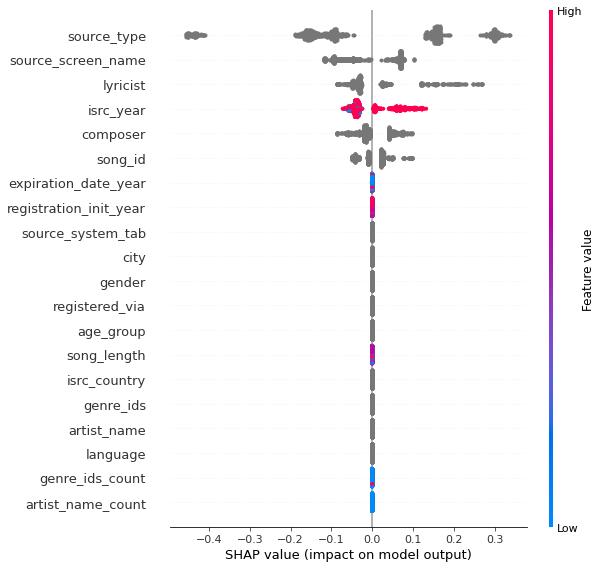

In [13]:
shap_catboost.show_shap_values()

#### Embeddings

In [14]:
%%time
embedding_model_v2 = EmbeddingModel_v2()
embedding_model_v2.fit(TRAIN_DATASET)

100%|██████████| 3537744/3537744 [07:29<00:00, 7878.03it/s]


CPU times: user 33min 54s, sys: 7.69 s, total: 34min 1s
Wall time: 21min


#### Similars

In [15]:
embedding_model_v2.get_similars("Beyoncé")

[('Jennifer Lopez', 0.8921063542366028),
 ("Destiny's Child", 0.8420911431312561),
 ('Britney Spears', 0.8413079977035522),
 ('Jessie J', 0.8336257934570312),
 ('Rihanna', 0.8268177509307861),
 ('Reggae Machine| Reggae Beat| Reggae Revolution', 0.8250247240066528),
 ('Ciara', 0.8233410120010376),
 ('Christina Aguilera', 0.820468544960022),
 ('Pussycat Dolls', 0.8185963034629822),
 ('Bobby Moon', 0.8127750158309937)]

In [16]:
embedding_model_v2.get_similars("OneRepublic")

[('Imagine Dragons', 0.9156079292297363),
 ('Wrabel', 0.895261287689209),
 ('Jack River', 0.8789340257644653),
 ('Gazzo', 0.8776142597198486),
 ('Bad Azz', 0.8745198249816895),
 ('Dashboard Confessional', 0.8737595677375793),
 ('Animals', 0.8709036111831665),
 ('Metro Karaoke', 0.8679194450378418),
 ('Soul Rebels Brass Band', 0.8677115440368652),
 ('Justin Oh', 0.867518424987793)]

In [17]:
embedding_model_v2.get_similars("Bruno Mars")

[('Mark Ronson feat. Bruno Mars', 0.9411507844924927),
 ('Maroon 5', 0.9223601222038269),
 ('Justin Timberlake', 0.8984118103981018),
 ('Wiz Khalifa', 0.8900537490844727),
 ('Lukas Graham', 0.8839576244354248),
 ('Adele', 0.8720732927322388),
 ('Justin Bieber', 0.8693662881851196),
 ('Fifth Harmony', 0.863613486289978),
 ('CHARLIE PUTH', 0.8615713715553284),
 ('Carly Rae Jepsen', 0.8596005439758301)]

In [18]:
embedding_model_v2.get_similars("Lady Gaga")

[('Ariana Grande', 0.8096489310264587),
 ('Sia', 0.804495096206665),
 ('Party Machine', 0.8037898540496826),
 ('P!nk', 0.796205997467041),
 ('Sky Blu', 0.793693482875824),
 ('A*Teens', 0.7936248779296875),
 ('Jessie J', 0.7905019521713257),
 ('Hailee Steinfeld', 0.7884995937347412),
 ('圓圓', 0.7867623567581177),
 ('Natalie Gang', 0.7774943709373474)]

In [19]:
embedding_model_v2.get_similars("Eminem")

[('Diddy - Dirty Money', 0.9130420684814453),
 ('T.A.C Nation', 0.9071429967880249),
 ('Flo Rida', 0.905792236328125),
 ('Lil Wayne| Wiz Khalifa| Imagine Dragons', 0.8995137810707092),
 ('Bad Meets Evil', 0.8736038208007812),
 ('Wiz Khalifa', 0.8640409708023071),
 ('N-DUBZ', 0.8635256290435791),
 ('Pitbull', 0.8632417917251587),
 ('Love Yourself', 0.8605417609214783),
 ('2 Chainz| Wiz Khalifa', 0.8577407598495483)]

In [20]:
# %%time
# embedding_model_v1 = EmbeddingModel_v1(embedding_dim=100, 
#                                     random_state=SEED, 
#                                     #  min_count=1)
#                                     min_count=5)

# embedding_auc_per_query = get_metric(embedding_model_v1, TRAIN_DATASET, n_splits=5)

In [21]:
# embedding_auc_per_query

#### Embeddings + CatBoost

In [22]:
# %%time
# stack_model = StackModel(loss_function="YetiRank", 
#                          iterations=150, 
#                         #  task_type="CPU",
#                          task_type="GPU",  
#                          random_state=SEED,
#                          embedding_dim=100,
#                         #  min_count=1)
#                          min_count=5)

# stack_scores = get_metric(stack_model, TRAIN_DATASET, n_splits=5)

In [23]:
# stack_scores

#### Shapley values

In [24]:
# %%time
# shap_stack = ShapValuesStackModel()
# shap_stack.fit(TRAIN_DATASET)

In [25]:
# shap_stack.show_shap_values()